In [22]:
import os
import pickle
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
def load_dataset(target_size):
    x, y = [], []
    base_path = "./data/images/"

    for dir in os.listdir(base_path):
        for image in os.listdir(os.path.join(base_path, dir)):
            image_path = os.path.join(base_path, dir, image)
            image = Image.open(image_path)
            rgb_image = image.copy().convert("RGB")
            x.append(np.array(rgb_image.resize(target_size), dtype=np.uint8))
            y.append(dir)

    return x, y

In [3]:
target_size = (224, 224)

In [4]:
metadata = pd.read_csv("./data/metadata.csv")
meta_filter = metadata[["Channel", "Category"]]
meta_filter = meta_filter.drop_duplicates()
meta_dict = meta_filter.set_index("Channel")["Category"].to_dict()

In [5]:
x, y = load_dataset(target_size)

class: Abroad in Japan


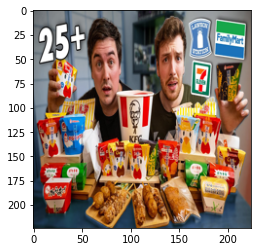

In [6]:
plt.imshow(x[100])
print(f"class: {y[100]}")

In [7]:
y = [meta_dict[item] for item in y]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

In [20]:
with open('le_classes.pkl', 'wb') as f:
    pickle.dump(le.classes_, f)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y_one_hot, test_size=0.2, random_state=42)
num_classes = len(set(y))

x_train = np.array(x_train)
x_test = np.array(x_test)

print(f"Train size: {len(y_train)} --- Test size: {len(y_test)}")

Train size: 1842 --- Test size: 461


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [10]:
train_generator = train_datagen.flow(
    x_train,
    y_train, 
    batch_size=32,
    shuffle=True
)

test_generator = test_datagen.flow(
    x_test,
    y_test,
    batch_size=32,
    shuffle=False
)

In [25]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=target_size+(3,))

In [26]:
for layer in base_model.layers:
    layer.trainable = False

In [27]:
dropout = 0.3

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(dropout))
model.add(Dense(256, activation="relu"))
model.add(Dropout(dropout))
model.add(Dense(64, activation="relu"))
model.add(Dropout(dropout))
model.add(Dense(len(le.classes_)))

In [31]:
model.compile(optimizer=Adam(learning_rate=1e-02), loss="categorical_crossentropy", metrics=["accuracy"])

In [32]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stop, reduce_lr],
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Epoch 1/100
58/58 [==============================] - 19s 230ms/step - loss: 8.0902 - accuracy: 0.0776 - val_loss: 7.7269 - val_accuracy: 0.1106 - lr: 0.0100
Epoch 2/100
58/58 [==============================] - 11s 188ms/step - loss: 8.0943 - accuracy: 0.1075 - val_loss: 7.7269 - val_accuracy: 0.1106 - lr: 0.0100
Epoch 3/100
58/58 [==============================] - 11s 188ms/step - loss: 7.8240 - accuracy: 0.1021 - val_loss: 7.7269 - val_accuracy: 0.1106 - lr: 0.0100
Epoch 4/100
58/58 [==============================] - 11s 187ms/step - loss: 8.2078 - accuracy: 0.0831 - val_loss: 7.7269 - val_accuracy: 0.1106 - lr: 0.0100
Epoch 5/100
58/58 [==============================] - 11s 189ms/step - loss: 8.3133 - accuracy: 0.0961 - val_loss: 7.7269 - val_accuracy: 0.1106 - lr: 0.0100
Epoch 6/100
58/58 [==============================] - 11s 188ms/step - loss: 7.8580 - accuracy: 0.0972 - val_loss: 8.3923 - val_accuracy: 0.1106 - lr: 0.0100
Epoch 7/100
58/58 [==============================] - 11s 1

KeyboardInterrupt: 

Accuracy of 9.98%


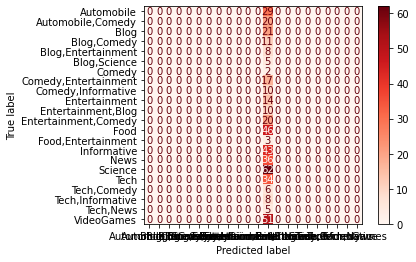

In [30]:
pred = model.predict(x_test)
predictions = np.argmax(pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
acc = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Accuracy of {round(acc*100, 2)}%")
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cm_display.plot(cmap="Reds")

In [17]:
model.save("Inception_0933.h5")

# Grad Cam